In [568]:
#file Locations
trainTxtLocation = "/Users/pranav/Desktop/CS584/HW3/Train.txt"
testTxtLocation ="/Users/pranav/Desktop/CS584/HW3/Test.txt"
outputTxtLocation="/Users/pranav/Desktop/CS584/HW3/output.txt"

In [569]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [570]:
ensemble_size = 220

# Reading Train Data

In [571]:
#read file
k = np.loadtxt(trainTxtLocation, delimiter=',')
Y=k[:, 1:]#data

X=k[:, 0].reshape(-1, 1)#res

In [572]:
X

array([[5.],
       [3.],
       [3.],
       ...,
       [3.],
       [3.],
       [3.]])

In [573]:
Y

array([[-1.   , -1.   , -1.   , ..., -0.671, -0.828, -1.   ],
       [-1.   , -1.   , -1.   , ..., -0.883, -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       ...,
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])

# ADA boost implementation

In [574]:
initweight = np.ones(len(Y)) / len(Y) 

In [575]:
def random(siz,weights):
    percentPartition=int( .05 * siz)
    return np.random.choice(int(siz), percentPartition, replace=True, p=weights)

In [576]:
def calculatePercent(newY):
    sumOfY=sum(newY)
    totalY=newY.shape[0]
    return (sumOfY/totalY)*100

In [577]:
def resample(data, res, weights):
    trainingDataNew = []
    trainingResultNew = []
    
    size = len(data)
    indexes = random(size,weights)
    
    for i in indexes:
         trainingDataNew.append(data[i])
         trainingResultNew.append(res[i])
        
    newX=np.array(trainingResultNew)
    
    newY=(newX==3).astype(int)
    print("3 ->  %0.2f" %calculatePercent(newY))
    five=100-calculatePercent(newY)
    print("5 ->  %0.2f" %five)
    return np.array(trainingDataNew), np.array(trainingResultNew)

In [578]:
def enum(pred,res):
    obj=zip(pred,res)
    return enumerate(obj)

In [579]:
def findMissClassificatonIndex(predict, res, weight):
    print("accuracy of this tree : ",accuracy_score(res, predict))
    incorrectIndex= []
    rateOfErr = 0
    indexMiss = []
    
    for i, (pred, trueRes) in enum(predict, res):
        if pred != trueRes:
            indexMiss.append(i)
            incorrectIndex.append((i, pred, trueRes))
            rateOfErr = rateOfErr + weight[i]
            
    rateOfErr = rateOfErr / len(predict)
    return rateOfErr, indexMiss

In [580]:
def updateWeight(missmatch, weight, alpha):
    new_weight = []
    normalizationConst = 0
    weightIdx = 0
    misMatchIdx = 0
    
    
    while weightIdx < len(weight):
        if misMatchIdx < len(missmatch) and missmatch[misMatchIdx] == weightIdx:
            expAlp=math.exp(alpha)
            fctr = weight[weightIdx] * expAlp
            misMatchIdx=misMatchIdx+1
        else:
            expAlp = math.exp(-1*alpha)
            fctr = weight[weightIdx] * expAlp
            
        new_weight.append( fctr )
        weightIdx = weightIdx+ 1
        normalizationConst =normalizationConst+ fctr

    return new_weight / normalizationConst

In [581]:
def calcSay(errRate):
    say=(1-(errRate+0.0001)) / (errRate+0.0001)
    say = ( math.log( say ) )
    return 0.2 * say

# Decision Tree Implemtation

In [582]:
def maxElem(elem):
        el= np.argmax(elem)
        return el

In [583]:
def findUniqAndCount(elem):
    clas, count = np.unique(elem, return_counts=True)
    return clas, count

In [584]:
import numpy as np

class DecisionTreeStump:
    
    def giniIndex(self, y):
        gini = 1.0
        classes, counts = findUniqAndCount(y)
        Ysamples = len(y)
        for clas in classes:
            temp = np.sum(y == clas) / Ysamples
            temp2=temp ** 2
            gini = gini-(temp2)
        return gini
    
    def majority(self, x):
        classes, counts = findUniqAndCount(x)
        return classes[maxElem(counts)]
    
    def fit(self, X, y):
        Ysamples, Xfeatures = X.shape
        self.impur = float('inf')
        
        for i in range(Xfeatures):
            feature = X[:, i]
            for threshold in feature:
                Xleft = y[feature <= threshold]
                Xright = y[feature > threshold]
                zero=0
                if len(Xleft) == zero or len(Xright) == zero:
                    continue
                
                gini_left = self.giniIndex(Xleft)
                gini_right = self.giniIndex(Xright)
                lt=gini_left * len(Xleft) / Ysamples
                rt=gini_right * len(Xright) / Ysamples
                impur = lt + gini_right * rt
                
                if impur < self.impur:
                    self.index = i
                    self.threshold = threshold
                    self.Xlabel = self.majority(Xright)
                    self.Ylabel = self.majority(Xleft)
                    self.impur = impur
    
    def predict(self, X):
        yprd= np.where(X[:, self.index] <= self.threshold, self.Ylabel, self.Xlabel)
        return yprd
    
    def __init__(self):
        self.impur = None
        self.threshold = None
        self.Xlabel = None
        self.Ylabel = None
        self.index = None

# Calling Method

In [585]:
from sklearn.tree import DecisionTreeClassifier

ensemble = []
alphas = []
def adaBoostingCaller(weights):

    for i in range(ensemble_size):
        print("iteration Number - ",i)
        sampledFetures, sampledRes = resample(Y, X, weights)
        tree = DecisionTreeStump()
        tree.fit(sampledFetures, sampledRes)
        predicted_result = tree.predict(Y)
        
        errRate, errIdx = findMissClassificatonIndex(predicted_result, X, weights)
        say=calcSay(errRate)
        
        alphas.append(say)
        ensemble.append(tree)
        
        weights = updateWeight(errIdx, weights, say)

In [586]:
adaBoostingCaller(initweight)

iteration Number -  0
3 ->  43.33
5 ->  56.67
accuracy of this tree :  0.7331136738056013
iteration Number -  1
3 ->  78.33
5 ->  21.67
accuracy of this tree :  0.26688632619439867
iteration Number -  2
3 ->  48.33
5 ->  51.67
accuracy of this tree :  0.6598023064250412
iteration Number -  3
3 ->  68.33
5 ->  31.67
accuracy of this tree :  0.6902800658978583
iteration Number -  4
3 ->  28.33
5 ->  71.67
accuracy of this tree :  0.30971993410214166
iteration Number -  5
3 ->  65.00
5 ->  35.00
accuracy of this tree :  0.8138385502471169
iteration Number -  6
3 ->  55.00
5 ->  45.00
accuracy of this tree :  0.3467874794069193
iteration Number -  7
3 ->  35.00
5 ->  65.00
accuracy of this tree :  0.729818780889621
iteration Number -  8
3 ->  75.00
5 ->  25.00
accuracy of this tree :  0.5831960461285008
iteration Number -  9
3 ->  31.67
5 ->  68.33
accuracy of this tree :  0.41680395387149916
iteration Number -  10
3 ->  80.00
5 ->  20.00
accuracy of this tree :  0.27347611202635913
iterat

accuracy of this tree :  0.5675453047775947
iteration Number -  91
3 ->  83.33
5 ->  16.67
accuracy of this tree :  0.5543657331136738
iteration Number -  92
3 ->  23.33
5 ->  76.67
accuracy of this tree :  0.4456342668863262
iteration Number -  93
3 ->  83.33
5 ->  16.67
accuracy of this tree :  0.4958813838550247
iteration Number -  94
3 ->  36.67
5 ->  63.33
accuracy of this tree :  0.4942339373970346
iteration Number -  95
3 ->  80.00
5 ->  20.00
accuracy of this tree :  0.6054365733113674
iteration Number -  96
3 ->  21.67
5 ->  78.33
accuracy of this tree :  0.6350906095551895
iteration Number -  97
3 ->  53.33
5 ->  46.67
accuracy of this tree :  0.4695222405271829
iteration Number -  98
3 ->  8.33
5 ->  91.67
accuracy of this tree :  0.4489291598023064
iteration Number -  99
3 ->  75.00
5 ->  25.00
accuracy of this tree :  0.4942339373970346
iteration Number -  100
3 ->  23.33
5 ->  76.67
accuracy of this tree :  0.514827018121911
iteration Number -  101
3 ->  76.67
5 ->  23.33

accuracy of this tree :  0.5963756177924218
iteration Number -  181
3 ->  45.00
5 ->  55.00
accuracy of this tree :  0.46622734761120266
iteration Number -  182
3 ->  15.00
5 ->  85.00
accuracy of this tree :  0.5172981878088962
iteration Number -  183
3 ->  70.00
5 ->  30.00
accuracy of this tree :  0.5370675453047776
iteration Number -  184
3 ->  10.00
5 ->  90.00
accuracy of this tree :  0.45799011532125206
iteration Number -  185
3 ->  80.00
5 ->  20.00
accuracy of this tree :  0.5683690280065898
iteration Number -  186
3 ->  30.00
5 ->  70.00
accuracy of this tree :  0.5626029654036244
iteration Number -  187
3 ->  63.33
5 ->  36.67
accuracy of this tree :  0.33772652388797364
iteration Number -  188
3 ->  23.33
5 ->  76.67
accuracy of this tree :  0.7883031301482701
iteration Number -  189
3 ->  38.33
5 ->  61.67
accuracy of this tree :  0.4588138385502471
iteration Number -  190
3 ->  50.00
5 ->  50.00
accuracy of this tree :  0.7520593080724877
iteration Number -  191
3 ->  71.

In [589]:
def maj(pa,na):
    if pa >=na:
        return 3
    else:
        return 5

In [590]:
def predMajRes(Y, esize):
    data = []
    for j in range(len(Y)):
        na =0
        pa=0
        
        for i in range(esize):
            z = Y[j].reshape((1,Y[j].shape[0]))
            k = ensemble[i].predict(z)
            if k[0] == 3:
                pa += alphas[i]
            elif k[0] == 5:
                na+=alphas[i]
        
        data.append(maj(pa,na))
    return data

# Train data Prediction for AdaBoost using decision stumps

In [591]:
trainAccArray = []
ensembleSizeArray=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220]
for i in ensembleSizeArray:
    data = predMajRes(Y, i)
    acc=accuracy_score(X, data)
    trainAccArray.append(acc)
print(trainAccArray)

[0.7215815485996705, 0.6021416803953872, 0.8253706754530478, 0.8682042833607908, 0.9044481054365733, 0.9200988467874794, 0.9242174629324547, 0.9299835255354201, 0.929159802306425, 0.943986820428336, 0.9588138385502472, 0.957166392092257, 0.9563426688632619, 0.9505766062602965, 0.9662273476112027, 0.9654036243822076, 0.9629324546952224, 0.9728171334431631, 0.9736408566721582, 0.9769357495881383, 0.9827018121911038, 0.9901153212520593]


In [592]:
trainErrArray=[]
for i in trainAccArray:
    err=1-i
    trainErrArray.append(err)
print(trainErrArray) 

[0.2784184514003295, 0.3978583196046128, 0.17462932454695224, 0.1317957166392092, 0.09555189456342672, 0.07990115321252056, 0.07578253706754534, 0.07001647446457993, 0.07084019769357497, 0.05601317957166396, 0.041186161449752845, 0.04283360790774304, 0.04365733113673809, 0.0494233937397035, 0.03377265238879734, 0.034596375617792385, 0.03706754530477763, 0.027182866556836882, 0.02635914332784184, 0.023064250411861664, 0.017298187808896248, 0.009884678747940745]


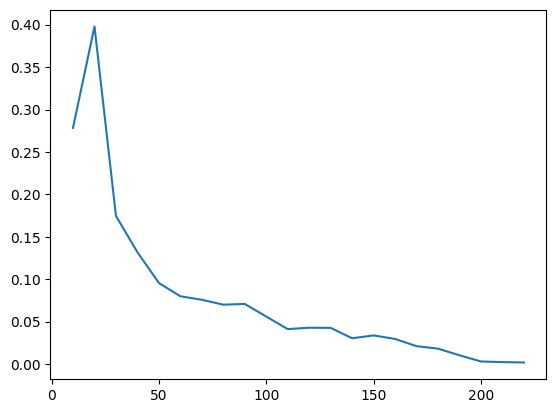

In [706]:
plt.plot(ensembleSizeArray, trainErrArray)

# Reading Test data for AdaBoost using decision stumps

In [707]:
testDataAdaBoost = np.loadtxt(testTxtLocation, delimiter=',')

In [708]:
numberOfStumps=220

In [709]:
dataTest = predMajRes(testDataAdaBoost, numberOfStumps)
len(dataTest)

326

In [710]:
outputTxtLocation="/Users/pranav/Desktop/CS584/HW3/outputTest200.txt"
#write file
with open(outputTxtLocation, 'w') as outputFile:
    for i in range(len(dataTest)):
        if(dataTest[i]==3):
            outputFile.write("3"+'\n')
        else:
            outputFile.write("5"+'\n')
print("Execution finished")  

Execution finished


## Following is the reading recorded from miner2
<table><th><td><b>Ensemble size<b/><td/><td><b>Accuracy<b/><td/> <th/> 
    <tr><td>10<td/><td>0.82<td/><tr/>
    <tr><td>20<td/><td>0.83<td/><tr/>
    <tr><td>30<td/><td>0.87<td/><tr/>
    <tr><td>40<td/><td>0.88<td/><tr/>
    <tr><td>50<td/><td>0.90<td/><tr/>
    <tr><td>60<td/><td>0.91<td/><tr/>
    <tr><td>70<td/><td>0.89<td/><tr/>
    <tr><td>80<td/><td>0.90<td/><tr/>
    <tr><td>90<td/><td>0.91<td/><tr/>
    <tr><td>100<td/><td>0.92<td/><tr/>
    <tr><td>110<td/><td>0.91<td/><tr/>
    <tr><td>120<td/><td>0.93<td/><tr/>
    <tr><td>130<td/><td>0.94<td/><tr/>
    <tr><td>140<td/><td>0.93<td/><tr/>
    <tr><td>150<td/><td>0.94<td/><tr/>
    <tr><td>160<td/><td>0.94<td/><tr/>
    <tr><td>170<td/><td>0.93<td/><tr/>
    <tr><td>180<td/><td>0.93<td/><tr/>
    <tr><td>190<td/><td>0.92<td/><tr/>
    <tr><td>200<td/><td>0.92<td/><tr/>
<table/>

In [712]:
testAccArray=[0.82,0.83,0.87,0.88,0.90,0.91,0.89,0.90,0.91,0.92,0.91,0.92,0.93,0.93,0.94,0.93,0.94,0.94,0.93,0.93,0.92,0.92]
testErrArray=[]
for i in testAccArray:
    err=1-i
    testErrArray.append(err)
print(testErrArray) 

[0.18000000000000005, 0.17000000000000004, 0.13, 0.12, 0.09999999999999998, 0.08999999999999997, 0.10999999999999999, 0.09999999999999998, 0.08999999999999997, 0.07999999999999996, 0.08999999999999997, 0.07999999999999996, 0.06999999999999995, 0.06999999999999995, 0.06000000000000005, 0.06999999999999995, 0.06000000000000005, 0.06000000000000005, 0.06999999999999995, 0.06999999999999995, 0.07999999999999996, 0.07999999999999996]


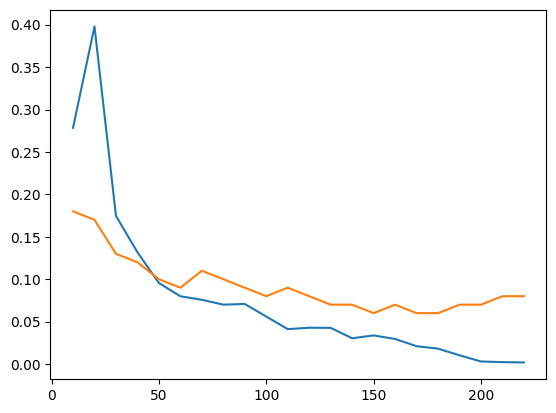

In [713]:
plt.plot(ensembleSizeArray, trainErrArray)
plt.plot(ensembleSizeArray, testErrArray)

# <b>Library Implementation</b>

In [714]:
newClassifier = DecisionTreeClassifier(criterion='gini', max_depth=None)

In [715]:
X

array([[5.],
       [3.],
       [3.],
       ...,
       [3.],
       [3.],
       [3.]])

In [716]:
Y

array([[-1.   , -1.   , -1.   , ..., -0.671, -0.828, -1.   ],
       [-1.   , -1.   , -1.   , ..., -0.883, -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       ...,
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])

In [717]:
newClassifier.fit(Y, X)

DecisionTreeClassifier()

In [718]:
x_pred = newClassifier.predict(Y)

In [719]:
x_pred

array([5., 3., 3., ..., 3., 3., 3.])

In [720]:
accuracy = accuracy_score(X, x_pred)
error=1-accuracy

In [721]:
print(accuracy)
print(err)

1.0
0.07999999999999996


# Reading test data for library implementation of Decision Tree

In [722]:
td = np.loadtxt(testTxtLocation, delimiter=',')

In [723]:
xt_pred = newClassifier.predict(td)

In [724]:
#write file
with open(outputTxtLocation, 'w') as outputFile:
    for i in range(len(xt_pred)):
        if(xt_pred[i]==3):
            outputFile.write("3"+'\n')
        else:
            outputFile.write("5"+'\n')
print("Execution finished")  

Execution finished


## Following is the reading recorded from miner2
### 0.91

In [725]:
libErrArr=[0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09]


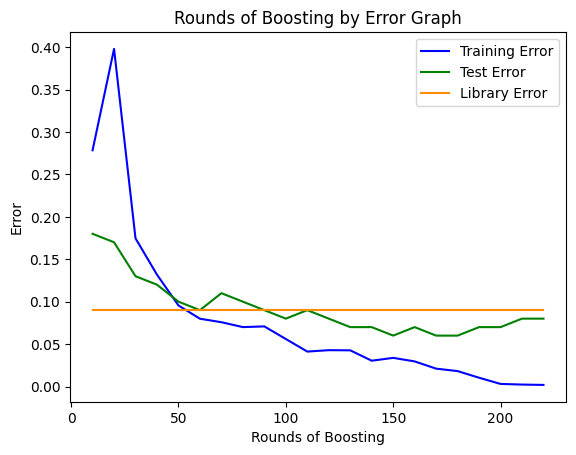

In [726]:
plt.plot(ensembleSizeArray, trainErrArray,color='blue', label='Training Error')
plt.plot(ensembleSizeArray, testErrArray,color='green', label='Test Error')
plt.plot(ensembleSizeArray, libErrArr,color='darkorange', label='Library Error')
plt.xlabel('Rounds of Boosting')
plt.ylabel('Error')
plt.title('Rounds of Boosting by Error Graph')
plt.legend(loc="upper right")
plt.show()